In [1]:
import gym
from keras import Sequential
from keras.layers import Dense
from keras.optimizers import adam
from keras.activations import relu, linear
import numpy as np
import random
from collections import deque
import matplotlib.pyplot as plt

Using TensorFlow backend.


## Условия окружения

LunarLander-v2
Landing pad is always at coordinates (0,0). Coordinates are the first two numbers in state vector. Reward for moving from the top of the screen to landing pad and zero speed is about 100..140 points. If lander moves away from landing pad it loses reward back. Episode finishes if the lander crashes or comes to rest, receiving additional -100 or +100 points. Each leg ground contact is +10. Firing main engine is -0.3 points each frame. Solved is 200 points. Landing outside landing pad is possible. Fuel is infinite, so an agent can learn to fly and then land on its first attempt. Four discrete actions available: do nothing, fire left orientation engine, fire main engine, fire right orientation engine.

Инициализируем окружение

In [2]:
env = gym.make('LunarLander-v2')

/home/obi-1-konobe/projects/mag/ml/task_6/gym/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Состояния описываются 8 параметрами

In [3]:
env.observation_space

Box(8,)

Существует 4 варианта действий

In [4]:
env.action_space.n

4

Инициализируем гиперпараметры

In [12]:
lr = 0.001
state_size = 8
n_actions = 4
exp_bufer = list()
epsilon = 1
min_epsilon = 0.1
gamma = 0.99
batch_size = 100

Инициализируем нейронную сеть

In [13]:
model = Sequential()
model.add(Dense(256, input_dim=state_size, activation=relu))
model.add(Dense(128, activation=relu))
model.add(Dense(n_actions, activation=linear))
model.compile(loss='mse', optimizer=adam(lr=lr))

Функция выбора действия по состоянию

In [14]:
def get_action(state):
    # exploartion vs explotation
    exploration_explotation =  random.random()
    if exploration_explotation < epsilon:
        random_action = env.action_space.sample()
        return random_action
    best_action = np.argmax(model.predict(state)[0])
    return best_action

Функция обновления весов сети

In [18]:
def update_weights():
    
    if np.mean(episodes_score[-10:]) > 200:
        return None
    # набирвем батч из буфера
    batch = random.sample(exp_bufer, batch_size)
    # рассчитываем значения Q-функции 
    states = np.array([i[0] for i in batch])
    actions = np.array([i[1] for i in batch])
    rewards = np.array([i[2] for i in batch])
    next_states = np.array([i[3] for i in batch])
    dones = np.array([i[4] for i in batch])
    
    states = np.squeeze(states)
    next_states = np.squeeze(next_states)
    
    targets = rewards + gamma*(np.amax(model.predict_on_batch(next_states), axis=1))*(1-dones)
    # подставляем новые значения Q-функции
    targets_full = model.predict_on_batch(states)
    ind = np.array([i for i in range(batch_size)])
    targets_full[[ind], [actions]] = targets
    # обновляем веса сети
    model.fit(states, targets_full, epochs=1, verbose=0)

Запускаем 10 эпизодов со случайными действиями для первичного заполнения буфера

In [16]:
for i in range(10):
    done = False
    state = env.reset()
    while not done:
        state = np.reshape(state, (1, 8))
        random_action = env.action_space.sample()
        env.render()
        next_state, reward, done, info = env.step(random_action)
        next_state = np.reshape(next_state, (1, 8))
        exp_bufer.append((state, random_action, reward, next_state, done))
        state = next_state
    
env.close()
print(len(exp_bufer))

906


Тренируем нейронную сеть

In [17]:
episodes_score = list()
for episode in range(500):
    state = env.reset()
    state = np.reshape(state, (1, state_size))
    cumulative_rewards = 0
    max_steps = 1500
    for i in range(max_steps):
        # выбираем действие
        action = get_action(state)
        # получаем новые параметры и сохраняем их в буфер
        env.render()
        next_state, reward, done, info = env.step(action)
        cumulative_rewards += reward
        next_state = np.reshape(next_state, (1, state_size))
        exp_bufer.append((state, action, reward, next_state, done))
        state = next_state
        # обновляем веса
        update_weights()
        # если эпизод закончился
        if done:
            print(f'episode {episode} score {cumulative_rewards}')
            # уменьшаем exploration
            if epsilon > min_epsilon:
                epsilon -= 0.01
            break
    # если последние 50 эпизодов закончились успешно, то дострочно прекращаем обучение 
    episodes_score.append(cumulative_rewards)
    if np.mean(episodes_score[-50:]) > 200:
        print('finish')
        break


/home/obi-1-konobe/projects/mag/ml/task_6/venv/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/obi-1-konobe/projects/mag/ml/task_6/venv/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


episode 0 score -370.20143976188683
episode 1 score -81.02456875386873
episode 2 score -170.59155919351699
episode 3 score -86.42804772527664
episode 4 score -133.7530028299251
episode 5 score -108.4282196814671
episode 6 score -95.52258141815865
episode 7 score -122.20574808381669
episode 8 score -162.53596190346843
episode 9 score -178.38832353962283
episode 10 score -87.19919357997227
episode 11 score -113.22040926491415
episode 12 score -158.20561761580043
episode 13 score -117.99554756055332
episode 14 score -109.27964927546036
episode 15 score -54.23980927074056
episode 16 score -75.54222545430711
episode 17 score -63.43861054439198
episode 18 score -108.68548875627289
episode 19 score -82.17990695207092
episode 20 score -87.5535212615678
episode 21 score -220.39640473185477
episode 22 score -66.04583350072085
episode 23 score -67.81494760664631
episode 24 score -55.56099613463399
episode 25 score -234.70260587759344
episode 26 score -59.65995645103658
episode 27 score -85.916831

episode 226 score -201.4793108865519
episode 227 score 264.56433568682525
episode 228 score 148.47449425171646
episode 229 score 265.5576139497889
episode 230 score 251.8416384503767
episode 231 score 64.8422816346829
episode 232 score -98.52190529388062
episode 233 score -11.996034998557679
episode 234 score 277.7548287726504
episode 235 score 8.127741399579024
episode 236 score 0.06812072817140802
episode 237 score 255.81859412124064
episode 238 score 290.1712603135727
episode 239 score 225.66284888491393
episode 240 score 255.33690440339532
episode 241 score 94.49955658668921
episode 242 score -190.86312067606534
episode 243 score 293.30232150854135
episode 244 score -405.46829825374857
episode 245 score 231.82650554648055
episode 246 score -137.49391431697453
episode 247 score 220.25518343154286
episode 248 score 277.06805960352347
episode 249 score 122.30092616551073
episode 250 score 295.2665064345787
episode 251 score 29.86070926285788
episode 252 score 252.92680667848217
episod

In [19]:
env.close()

Кривая обучения

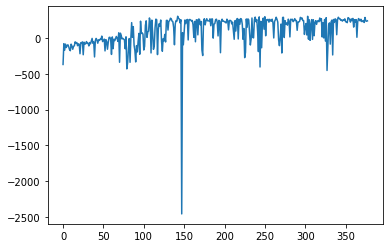

In [21]:
plt.plot(episodes_score)

Тестируем модель

In [26]:
test_score = list()
for i in range(10):
    done = False
    state = env.reset()
    score = 0
    while not done:
    
        state = np.reshape(state, (1, 8))
        action = np.argmax(model.predict(state)[0])
        env.render()
        next_state, reward, done, info = env.step(action)
        state = next_state
        score += reward
    test_score.append(score)
env.close()

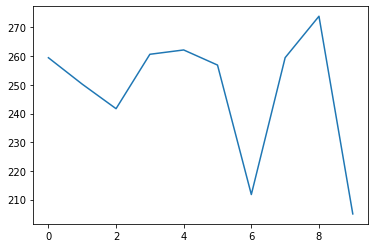

In [27]:
plt.plot(test_score)

Все прилунения закончились удачно (>200)